<a href="https://colab.research.google.com/github/Papadopoulos18/Fashion-Mnist-with-CNN-Pytorch/blob/main/Fashion_Mnist_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

#load the data

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(
    root = '.',
    train = True,
    transform=transforms.ToTensor(),                      #here it changes from (0,255) to (0,1)
    download=True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [ ]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [ ]:
test_dataset = torchvision.datasets.FashionMNIST(
    root = '.',
    train = False,
    transform=transforms.ToTensor(),
    download=True
)

In [ ]:
test_dataset.data.shape

torch.Size([10000, 28, 28])

number of classes

In [ ]:
K = len(set(train_dataset.targets.numpy()))     #train_dataset.targets->60000x1, .numpy->array([60000x1]),set->dict{0 to 9}
print(f'Number of classes are: {K}')

Number of classes are: 10


#Define the model

In [ ]:
from torch.nn.modules.activation import ReLU
from torch.nn.modules.linear import Linear
from torch.nn.modules import dropout
from torch.nn.modules.container import Sequential
class CNN(nn.Module):
  def __init__(self, K):
      super(CNN, self).__init__()
      self.conv_layers = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
          nn.ReLU(),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
          nn.ReLU(),
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
          nn.ReLU()
      )

      
      self.dense_layers = nn.Sequential(
          nn.Dropout(0.2),
          nn.Linear(128*2*2, 512),                  #2x2 ειναι τα spatial dimensions της εικονας απο το τελευταιο conv (O = flour((W-F+2P)/S + 1)), W=in, F=filter, P=pad, S=stride
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(512, K)
      )
      
  def forward(self, X):
    out = self.conv_layers(X)
    out = out.view(out.size(0), -1)               #out.size(0) -> batch size
    out = self.dense_layers(out)
    return out 


# instantiate the model
model = CNN(K)



# OR only with Sequential


```
# model = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
          nn.ReLU(),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
          nn.ReLU(),
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
          nn.ReLU(),
          nn.Flatten(),
          nn.Dropout(0.3),
          nn.Linear(63, 512),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(512, K)

)
```




#move the model to the GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

#loss and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

#Data loader
useful because it automatically generates batches in the training loop and takes care of shuffling

In [ ]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

#Training

In [ ]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs): 
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    tO = datetime.now()
    train_loss = []
    i = 0
    for inputs, targets in train_loader:

      i += 1
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradient
      optimizer.zero_grad()

      #forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    print(f'Nun of for(itarations): {i}')                                                         #how many itarations

    print(f'------{len(train_loss)}-------------------')                      # 469 losses οσα και τα itarations δλδ(469 φορες περναει το batch των 128)
    # get train loss and test loss
    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - tO
    print(f'Epoch {it + 1}/{epochs}, Train Loss: {train_loss: .4f}, \
    Test Loss: {test_loss: .4f}, duration: {dt}')

  return train_losses, test_losses


train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=1) 



Nun of for: 469
------469-------------------
Epoch 1/1, Train Loss:  0.2723,     Test Loss:  0.3249, duration: 0:00:13.893220


plot train loss and test loss per iteration


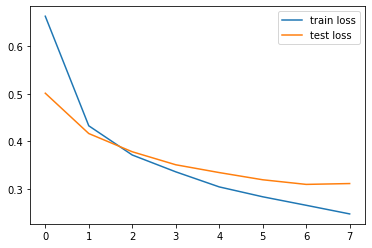

In [ ]:
plt.plot(train_losses, label= 'train loss')
plt.plot(test_losses, label= 'test loss')
plt.legend()
plt.show()


# Accuracy

In [ ]:
n_correct = 0.
n_total = 0.
i=0

for inputs, targets in train_loader:
  i+=1
  # move the data to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  if (i==1):
    print(inputs.shape)
  # forward pass
  outputs = model(inputs)

  # get predictions
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
  # print(targets.shape[0])                                                       # 128 128 ... (468 φορες) ... 96
  # print(n_correct, n_total)


train_acc = n_correct/n_total
# print("for ", i)
# print(inputs.shape)
# print(f'------{predictions.shape}--{outputs.shape}----{targets.shape}')       #96 γιατι ειναι το τελευταιο itaration(468*128 + 96(last for loop) = 60000)
n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  # forward pass
  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct/n_total

print(f'Train acc: {train_acc: .4f}, Test acc: {test_acc: .4f}')


  


torch.Size([128, 1, 28, 28])
117.0 128.0
236.0 256.0
348.0 384.0
462.0 512.0
580.0 640.0
693.0 768.0
808.0 896.0
924.0 1024.0
1039.0 1152.0
1149.0 1280.0
1267.0 1408.0
1387.0 1536.0
1506.0 1664.0
1618.0 1792.0
1729.0 1920.0
1840.0 2048.0
1952.0 2176.0
2065.0 2304.0
2183.0 2432.0
2302.0 2560.0
2409.0 2688.0
2529.0 2816.0
2648.0 2944.0
2763.0 3072.0
2880.0 3200.0
2998.0 3328.0
3106.0 3456.0
3227.0 3584.0
3343.0 3712.0
3460.0 3840.0
3577.0 3968.0
3696.0 4096.0
3814.0 4224.0
3931.0 4352.0
4047.0 4480.0
4156.0 4608.0
4275.0 4736.0
4394.0 4864.0
4514.0 4992.0
4631.0 5120.0
4749.0 5248.0
4864.0 5376.0
4982.0 5504.0
5094.0 5632.0
5211.0 5760.0
5327.0 5888.0
5445.0 6016.0
5558.0 6144.0
5677.0 6272.0
5788.0 6400.0
5906.0 6528.0
6020.0 6656.0
6135.0 6784.0
6245.0 6912.0
6360.0 7040.0
6477.0 7168.0
6597.0 7296.0
6714.0 7424.0
6832.0 7552.0
6950.0 7680.0
7069.0 7808.0
7185.0 7936.0
7294.0 8064.0
7417.0 8192.0
7538.0 8320.0
7660.0 8448.0
7779.0 8576.0
7896.0 8704.0
8015.0 8832.0
8130.0 8960.0
8247.0

#Confusion Matrix

Confusion Matrix without normalization
[[855   1  32  15   1   2  82   0  12   0]
 [  5 973   0  16   1   0   2   0   3   0]
 [ 13   2 852   9  29   0  87   0   8   0]
 [ 23   6  18 903  24   0  24   0   2   0]
 [  0   1 108  39 733   0 114   0   5   0]
 [  1   0   0   1   0 970   0  16   4   8]
 [147   0  74  23  70   0 667   0  19   0]
 [  0   0   0   0   0  13   0 949   0  38]
 [  1   0   4   2   1   1   8   3 980   0]
 [  1   0   0   0   0   6   0  34   1 958]]


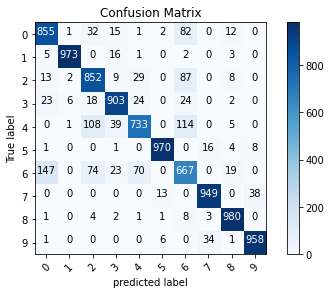

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  
  # This function prints and plots the confusion matrix.
  # Normalization can be applied by setting 'normalize=True'

  if normalize:
    cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis])
    print('Normalize confusion Matrix')
  else:
    print('Confusion Matrix without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i,j], fmt),
             horizontalalignment="center",
             color="white" if cm[i,j] > thresh else "black")
    
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('predicted label')
  plt.show()


# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
 
for inputs, targets in test_loader:
  # move date to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # forward pass
  outputs = model(inputs)

  # Get predictions
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [ ]:
# label mapping 
labels = '''T-shirt,
Trouser,
Pullover,
Dress,
Coat,
Sandal,
Shirt,
Sneaker,
Bag,
Ankle boot'''.split("\n")


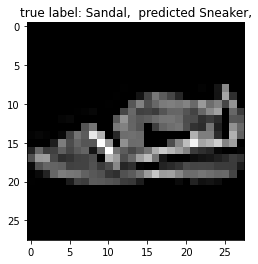

In [ ]:
# show some misclassified examples

p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap="gray")
plt.title("true label: %s  predicted %s" % (labels[y_test[i]], labels[p_test[i]]));